# Benchmarking Neural Nets with the XOR Problem

In [ ]:
import sklearn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

#1. THE DATASET AND VISUALIZATION


(720, 2)
(200, 2)
(80, 2)


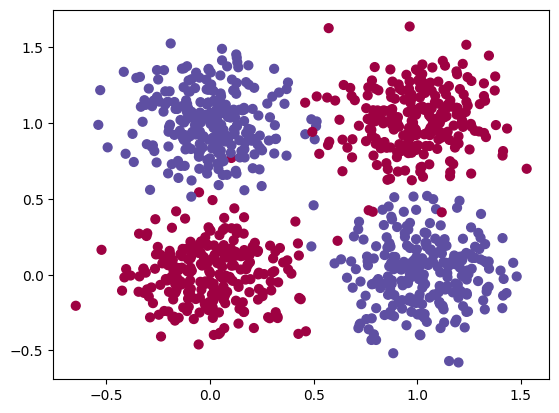

In [ ]:
def make_xor(n_points):
    centers = np.array([[0,0],[0,1],[1,0],[1,1]])
    labels = np.array([0,1,1,0])
    data = np.array([]).reshape(-1,3)
    for center, label in zip(centers,labels):
        points = np.random.normal(loc=center,scale=0.2,size=(n_points//4,2))
        points_labels = np.hstack((points,label*np.ones(n_points//4).reshape((-1, 1))))
        data = np.vstack((data,points_labels))
    return (data[:,[0,1]],data[:,2])


X, y = make_xor(1000)
y=y.astype(np.int64)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size= 0.1, random_state=49)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

# 2. TRAINING A SIMPLE ANN FOR CLASSIFICATION TASK

7/7 [==============================] - 0s 3ms/step - loss: 0.0882 - accuracy: 0.9650
Test Accuracy: 96.50%


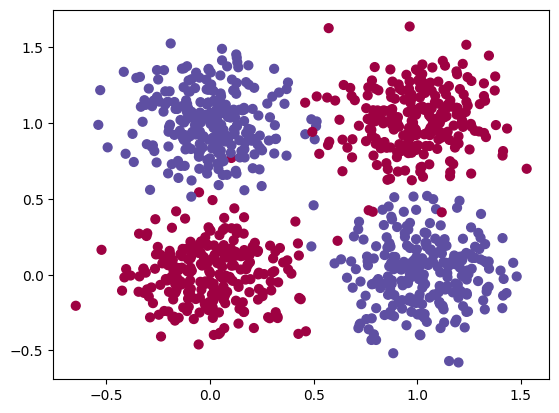

In [ ]:
import tensorflow as tf
from tensorflow import keras

my_model = keras.Sequential()

my_model.add(keras.layers.Input(shape=(2,)))
my_model.add(keras.layers.Dense(8, activation="relu"))
my_model.add(keras.layers.Dense(1, activation="sigmoid"))

my_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = my_model.fit(X_train, y_train, epochs=128, batch_size=32, validation_data=(X_val, y_val), verbose=0)

test_loss, test_acc = my_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

# 3. IMPLEMENTING MY OWN SIMPLE NEURAL NETWORK

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import OneHotEncoder

class MyNeuralNet(BaseEstimator):

    def __init__ (self, n0, n1, n2, alpha=0.01):
        """
        @param: n0: Number of nodes in the input layer
        @param: n1: Number of nodes in the hidden layer
        @param: n2: Number of nodes in the output layer
        @param: alpha: The Learning Rate
        """
        np.random.seed(42)
        self.W1 = np.random.randn(n1, n0)
        self.b1 = np.zeros((n1, 1))
        self.W2 = np.random.randn(n2, n1)
        self.b2 = np.zeros((n2, 1))

        self.alpha = alpha
        self.encoder = OneHotEncoder(sparse=False)

    def forward_pass(self, X):
        """
        Pass the signal forward through the layers.
        @param: X: feature
        @return: A1: saved value of the output of the hidden layer
        @return: A2: activated return value of the output layer.
        """

        Z1 = np.dot(self.W1, X) + self.b1
        A1 = np.tanh(Z1)
        Z2 = np.dot(self.W2, A1) + self.b2
        exp_x = np.exp(Z2 - np.max(Z2, axis=1, keepdims=True))
        A2 = exp_x / exp_x.sum(axis=1, keepdims=True)

        return A1, A2


    def loss(self, X, y):
        """
        Evaluate the total loss on the dataset
        @param: X: features
        @param: y: labels
        @return: L: the loss value
        """
        A1, A2 = self.forward_pass(X)
        Y = self.one_hot(y)
        L = -1/(X.shape[0]) * np.sum(Y * np.log(A2 + 1e-15))

        return L

    def backward_pass(self, A1, A2, X, y):
        """
        @param: X: feature
        @param: y: label
        @param: A1: saved value of the output of the hidden layer
        @param: a2: activated return value of the output layer.

        @return: dW1: the loss gradient of W1
        @return: db1: the loss gradient of b1
        @return: dW2: the loss gradient of W2
        @return: db2: the loss gradient of b2
        """
        m   = y.shape[0]
        dZ2 = A2 - self.one_hot(y)
        dW2 = np.dot(dZ2, A1.T)/m
        db2 = np.sum(dZ2, axis=1, keepdims=True)/m
        dZ1 = np.multiply( np.dot( self.W2.T, dZ2), 1-np.power( A1, 2))
        dW1 = np.dot(dZ1, X.T)/m
        db1 = np.sum(dZ1, axis=1, keepdims=True)/m

        return dW1, db1, dW2, db2


    def fit(self, X, y , epochs, X_val, Y_val):
        """
        Learns parameters for the neural network and returns the model.

        @param: X: the training feature
        @param: y: the train label
        @param: epochs: Number of passes through the training data for gradient descent
        @param: X_val: the feature of validation set
        @param: y_val: the label of validation set
        """

        if (X.shape[0] > X.shape[1]): X = X.T
        if (X_val.shape[0] > X_val.shape[1]): X_val = X_val.T

        for i in range(0, epochs):

            A1, A2 = self.forward_pass(X)
            dW1, db1, dW2, db2 = self.backward_pass(A1, A2, X, y)
            self.W1 -= self.alpha * dW1
            self.b1 -= self.alpha * db1
            self.W2 -= self.alpha * dW2
            self.b2 -= self.alpha * db2

            if i % 250 == 0:
                print("Epoch %i/%i - loss: %f - accuracy: %f - val_loss: %f - val_accuracy: %f"
                      %(i,epochs, self.loss(X, y), self.evaluate(X, y),
                        self.loss(X_val, y_val), self.evaluate(X_val,y_val)))

    def predict(self, X):
        """
        Predict label vector y
        """
        if (X.shape[0] > X.shape[1]): X = X.T
        A1, A2 = self.forward_pass(X)
        y_hat = np.argmax(A2, axis=0)

        return y_hat


    def evaluate(self, X, y):
        """
        Evaluate the accuracy of the model
        """
        m = y.shape[0]
        y_hat = self.predict(X)
        correct_y = (y_hat == y).astype(int)

        return sum(correct_y)/m


    def one_hot(self, y):
        """
        Utility function: Convert a label vector to one-hot vector
        """
        Y = self.encoder.fit_transform(y.reshape(len(y),1))
        return Y.T


    def plot_decision_boundary(self, X, y):
        """
        Utility Function: Plot a decision boundary for visualization purpose.
        If you don't fully understand this function don't worry, it just generates the contour plot below.
        """
        x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
        y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
        h = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        data_grid= np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(data_grid)
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)

#4. DOING COMPARISON BETWEEN MY IMPLEMENTATION TO THE STANDARD LIBRARY

Epoch 0/1000 - loss: 2462.908117 - accuracy: 0.476389 - val_loss: 185.736388 - val_accuracy: 0.550000
Epoch 250/1000 - loss: 2462.778103 - accuracy: 0.744444 - val_loss: 183.350005 - val_accuracy: 0.650000
Epoch 500/1000 - loss: 2410.058430 - accuracy: 0.763889 - val_loss: 176.724763 - val_accuracy: 0.675000
Epoch 750/1000 - loss: 2408.779689 - accuracy: 0.762500 - val_loss: 176.362179 - val_accuracy: 0.662500
Accuracy on the test set is  0.685


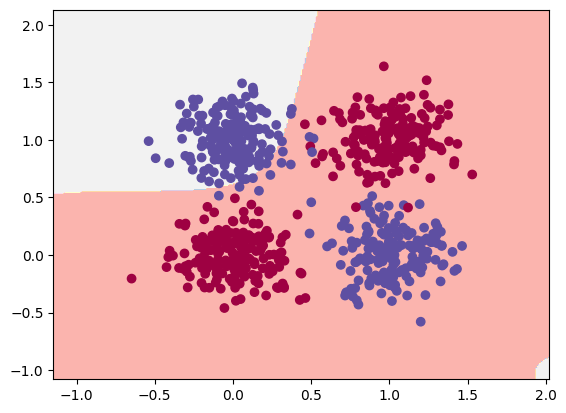

In [ ]:
import warnings
warnings.filterwarnings("ignore")

n0 = 2
n1 = 8
n2 = 2
alpha = 0.01
epochs = 1000

myModel1 = MyNeuralNet(n0, n1, n2, alpha);
myModel1.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel1.evaluate(X_test, y_test))

myModel1.plot_decision_boundary(X_train, y_train)

Epoch 0/1000 - loss: 4577.588288 - accuracy: 0.665278 - val_loss: 378.425207 - val_accuracy: 0.700000
Epoch 250/1000 - loss: 3518.775732 - accuracy: 0.740278 - val_loss: 263.031034 - val_accuracy: 0.725000
Epoch 500/1000 - loss: 3557.425776 - accuracy: 0.927778 - val_loss: 260.692942 - val_accuracy: 0.937500
Epoch 750/1000 - loss: 3438.115137 - accuracy: 0.900000 - val_loss: 251.477065 - val_accuracy: 0.887500
Accuracy on the test set is  0.82


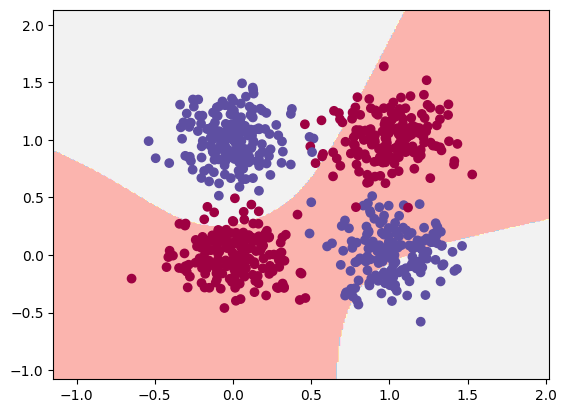

In [ ]:
n0 = 2
n1 = 64
n2 = 2
alpha = 0.01
epochs = 1000

myModel1 = MyNeuralNet(n0, n1, n2, alpha);
myModel1.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel1.evaluate(X_test, y_test))

myModel1.plot_decision_boundary(X_train, y_train)

Epoch 0/1000 - loss: 5803.991192 - accuracy: 0.673611 - val_loss: 517.467832 - val_accuracy: 0.737500
Epoch 250/1000 - loss: 9431.333552 - accuracy: 0.779167 - val_loss: 1018.858960 - val_accuracy: 0.800000
Epoch 500/1000 - loss: 8958.145040 - accuracy: 0.770833 - val_loss: 935.631628 - val_accuracy: 0.800000
Epoch 750/1000 - loss: 7959.481199 - accuracy: 0.787500 - val_loss: 793.190471 - val_accuracy: 0.800000
Accuracy on the test set is  0.795


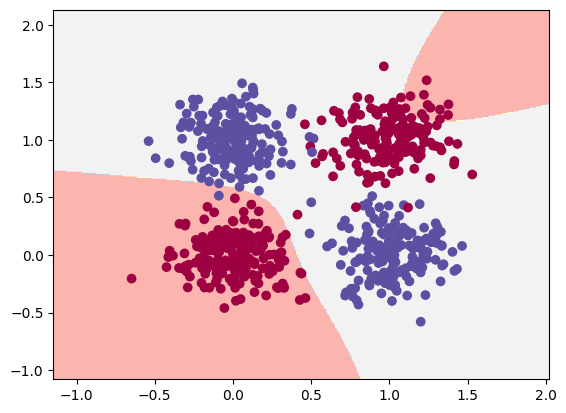

In [ ]:
n0 = 2
n1 = 512
n2 = 2
alpha = 0.01
epochs = 1000

myModel1 = MyNeuralNet(n0, n1, n2, alpha);
myModel1.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel1.evaluate(X_test, y_test))

myModel1.plot_decision_boundary(X_train, y_train)

7/7 [==============================] - 0s 5ms/step - loss: 0.0882 - accuracy: 0.9650
Test Accuracy: 96.50%


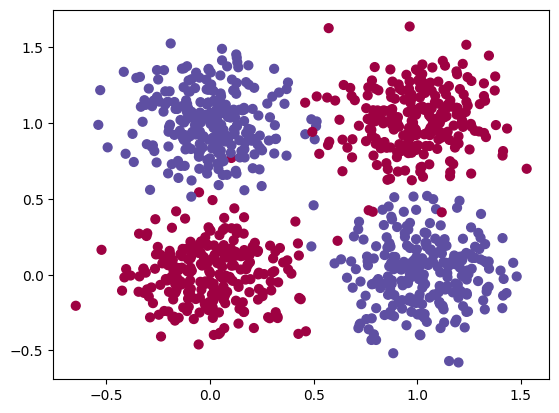

In [ ]:
# COMPARISONS WITH THE STANDARD LIBRARY
test_loss, test_acc = my_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

# Reflection
My own network seemed to perform signifcantly worse than the standard library. Which I can't really seem to figure out why. Specifically, 8 nodes in the hidden layer seemed to be the best for the stanard library, but a much higher node count around 64 seemed to be better for my own implementation. This could be due to the optimizer for my own implementation to be SGD and the optimizer for the standard library being adam. I was also able to use a much smaller epochs for the stanard library so it didn't have to run as much and still get a higher pecentage accuracy. My model ran a lot faster than the standard library so it was okay for me to do more epochs.